# DeepCross 广告点击率预测

谷歌的DeepCross系列模型(DCN-vector, DCN-matrix, DCN-mix) 围绕解决的核心问题是三高问题。

如何实现 高效率，高表达能力 的 高阶显式特征交叉？

本范例演示使用 torchkeras.tabular.DeepCrossModel 模型 进行广告点击率预测。

有关DeepCross模型的详细理论介绍和代码讲解，参考如下eat_pytorch_in_20_days中的讲解教程：

https://github.com/lyhue1991/eat_pytorch_in_20_days/blob/master/7-6%2CDeepCross%E6%A8%A1%E5%9E%8B.ipynb


公众号**算法美食屋**后台回复关键词：torchkeras，获取本文notebook源码和所用criteo_small数据集下载链接。


## 一，准备数据

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

np.random.seed(42)


In [2]:
from sklearn.preprocessing import LabelEncoder

dfdata = pd.read_csv('criteo_small.zip',sep='\t',header=None)
dfdata.columns = ["label"] + ["I"+str(x) for x in range(1,14)] + [
    "C"+str(x) for x in range(14,40)]

target_col = 'label'
cat_cols = [x for x in dfdata.columns if x.startswith('C')]
num_cols = [x for x in dfdata.columns if x.startswith('I')]


In [3]:
dftrain_val,dftest_raw = train_test_split(dfdata,test_size=0.2,random_state=42)
dftrain_raw,dfval_raw = train_test_split(dftrain_val,test_size=0.2,random_state=42)


In [4]:
from torchkeras.tabular import TabularPreprocessor
from sklearn.preprocessing import OrdinalEncoder

#特征工程
pipe = TabularPreprocessor(cat_features = cat_cols, onehot_max_cat_num=3)
encoder = OrdinalEncoder()

dftrain = pipe.fit_transform(dftrain_raw.drop(target_col,axis=1))
dftrain[target_col] = encoder.fit_transform(
    dftrain_raw[target_col].values.reshape(-1,1)).astype(np.int32)

dfval = pipe.transform(dfval_raw.drop(target_col,axis=1))
dfval[target_col] = encoder.transform(
    dfval_raw[target_col].values.reshape(-1,1)).astype(np.int32)

dftest = pipe.transform(dftest_raw.drop(target_col,axis=1))
dftest[target_col] = encoder.transform(
    dftest_raw[target_col].values.reshape(-1,1)).astype(np.int32)


2024-09-04 11:15:15.283899: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-04 11:15:15.333447: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-04 11:15:16.051500: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


  0%|          | 0/24 [00:00<?, ?it/s]

In [6]:
from torchkeras.tabular import TabularDataset
from torch.utils.data import Dataset,DataLoader 

def get_dataset(dfdata):
    return TabularDataset(
                data = dfdata,
                task = 'binary', # regression,binary,multiclass
                target = [target_col],
                continuous_cols = pipe.get_numeric_features(),
                categorical_cols = pipe.get_embedding_features()
        )

def get_dataloader(ds,batch_size=512,num_workers=0,shuffle=False):
    dl = DataLoader(
            ds,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            pin_memory=False,
        )
    return dl 
    
ds_train = get_dataset(dftrain)
ds_val = get_dataset(dfval)
ds_test = get_dataset(dftest)

dl_train = get_dataloader(ds_train,batch_size=2048,num_workers=4,shuffle=True)
dl_val = get_dataloader(ds_val,batch_size=2048,shuffle=False)
dl_test = get_dataloader(ds_test,batch_size=2048,shuffle=False)



In [7]:
for batch in dl_train:
    break

## 二，定义模型

In [15]:
from torchkeras.tabular.models import DeepCrossConfig,DeepCrossModel

model_config = DeepCrossConfig(
    task="binary",
    input_embed_max = 32, 
    cross_type = "mix",
    cross_order = 2,
    experts_num=8,
    low_rank=16,
    mlp_layers = "64-32",
    mlp_dropout=0.10,
    stacked = False
)
config = model_config.merge_dataset_config(ds_train)

print('input_embed_max = ', config.input_embed_max)
print('\n categorical_cardinality = ',config.categorical_cardinality)


input_embed_max =  32

 categorical_cardinality =  [1000, 529, 1000, 1000, 246, 15, 1000, 502, 1000, 1000, 1000, 1000, 26, 1000, 1000, 10, 1000, 1000, 1000, 16, 15, 1000, 63, 1000]


In [16]:
net = DeepCrossModel(config = config)

#初始化参数
net.reset_weights()
net.data_aware_initialization(dl_train)



In [17]:
output = net.forward(batch)
loss = net.compute_loss(output,batch['target'])
print(loss)

tensor(0.8986, grad_fn=<AddBackward0>)


## 三，训练模型

In [18]:
from torchkeras import KerasModel 
from torchkeras.tabular import StepRunner 
KerasModel.StepRunner = StepRunner 

import torch 
from torchkeras.metrics import AUC 

optimizer = torch.optim.AdamW(net.parameters(),lr = 1e-3)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, 
#                                                steps_per_epoch=len(dl_train), epochs=20)
keras_model = KerasModel(net,
                   loss_fn=None,
                   optimizer = optimizer,
                   metrics_dict = {'auc':AUC()}
                   )


Detected kernel version 5.4.186, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


<<<<<< ⚡️ cuda is used >>>>>>


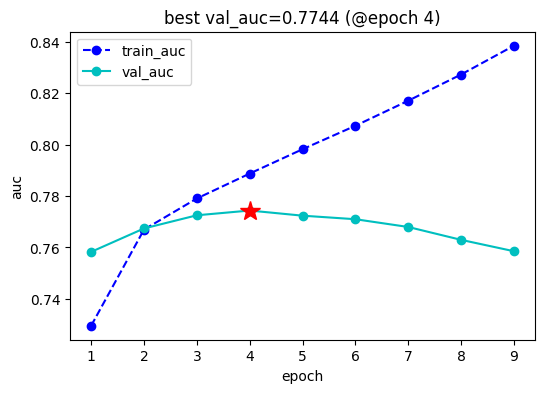

<<<<<< val_auc without improvement in 5 epoch,early stopping >>>>>> 



,epoch,train_loss,train_auc,lr,val_loss,val_auc
0,1,0.502081,0.729498,0.001,0.482687,0.758260
1,2,0.476161,0.766935,0.001,0.475403,0.767376
2,3,0.466756,0.779043,0.001,0.472124,0.772503
3,4,0.458923,0.788747,0.001,0.471000,0.774352
4,5,0.450944,0.798224,0.001,0.473214,0.772352
5,6,0.442793,0.807358,0.001,0.476765,0.770972
6,7,0.433664,0.817111,0.001,0.481727,0.767948
7,8,0.423271,0.827317,0.001,0.488020,0.762941
8,9,0.411726,0.838532,0.001,0.498512,0.758509


In [19]:
keras_model.fit(
    train_data = dl_train,
    val_data= dl_val,
    ckpt_path='checkpoint',
    epochs=30,
    patience=5,
    monitor="val_auc", 
    mode="max",
    plot = True,
    wandb = False
)

## 四，评估模型

In [20]:
keras_model.evaluate(dl_train)

100%|██████████████████████████████| 313/313 [00:48<00:00,  6.52it/s, val_auc=0.803, val_loss=0.448]


{'val_loss': 0.44789067443948205, 'val_auc': 0.8027271032333374}

In [21]:
keras_model.evaluate(dl_val)

100%|████████████████████████████████| 79/79 [00:13<00:00,  5.92it/s, val_auc=0.774, val_loss=0.471]


{'val_loss': 0.4709997256345387, 'val_auc': 0.7743517756462097}

In [23]:
keras_model.evaluate(dl_test)

100%|████████████████████████████████| 98/98 [00:16<00:00,  6.05it/s, val_auc=0.771, val_loss=0.473]


{'val_loss': 0.47254799336803205, 'val_auc': 0.7712969183921814}

## 五，使用模型

In [24]:
from tqdm import tqdm 

net,dl_test = keras_model.accelerator.prepare(net,dl_test)
net.eval()
preds = []
with torch.no_grad():
    for batch in tqdm(dl_test):
        preds.append(net.predict(batch))
    

100%|██████████| 98/98 [00:02<00:00, 36.83it/s]


In [25]:
yhat_list = [yd.sigmoid().reshape(-1).tolist() for yd in preds]
yhat = []
for yd in yhat_list:
    yhat.extend(yd)

In [26]:
dftest_raw = dftest_raw.rename(columns = {target_col: 'y'})
dftest_raw['yhat'] = yhat

In [27]:
from sklearn.metrics import roc_auc_score
roc_auc_score(dftest_raw['y'],dftest_raw['yhat'])

0.7712972015680227

## 六，保存模型

最佳模型权重已经保存在ckpt_path = 'checkpoint'位置了。

In [ ]:
net.load_state_dict(torch.load('checkpoint'))